# 全文搜索
即 关键词搜索，基于 BM25 算法，在 milvus 中，可以将原始文本转换为 稀疏向量。

# 大概流程
1. 文本输入：提供原始文本
2. 文本分析：Milvus 使用分析器将输入文本标记为可搜索的单个术语。
3. 函数处理：内置函数接收标记化术语，并将其`转换为稀疏向量`表示。
4. Collections 存储：Milvus 将这些稀疏嵌入存储在 Collections 中，以便高效检索。
5. BM25 评分：在搜索过程中，Milvus 应用 BM25 算法为存储的文档计算分数，并根据与查询文本的相关性对匹配结果进行排序。

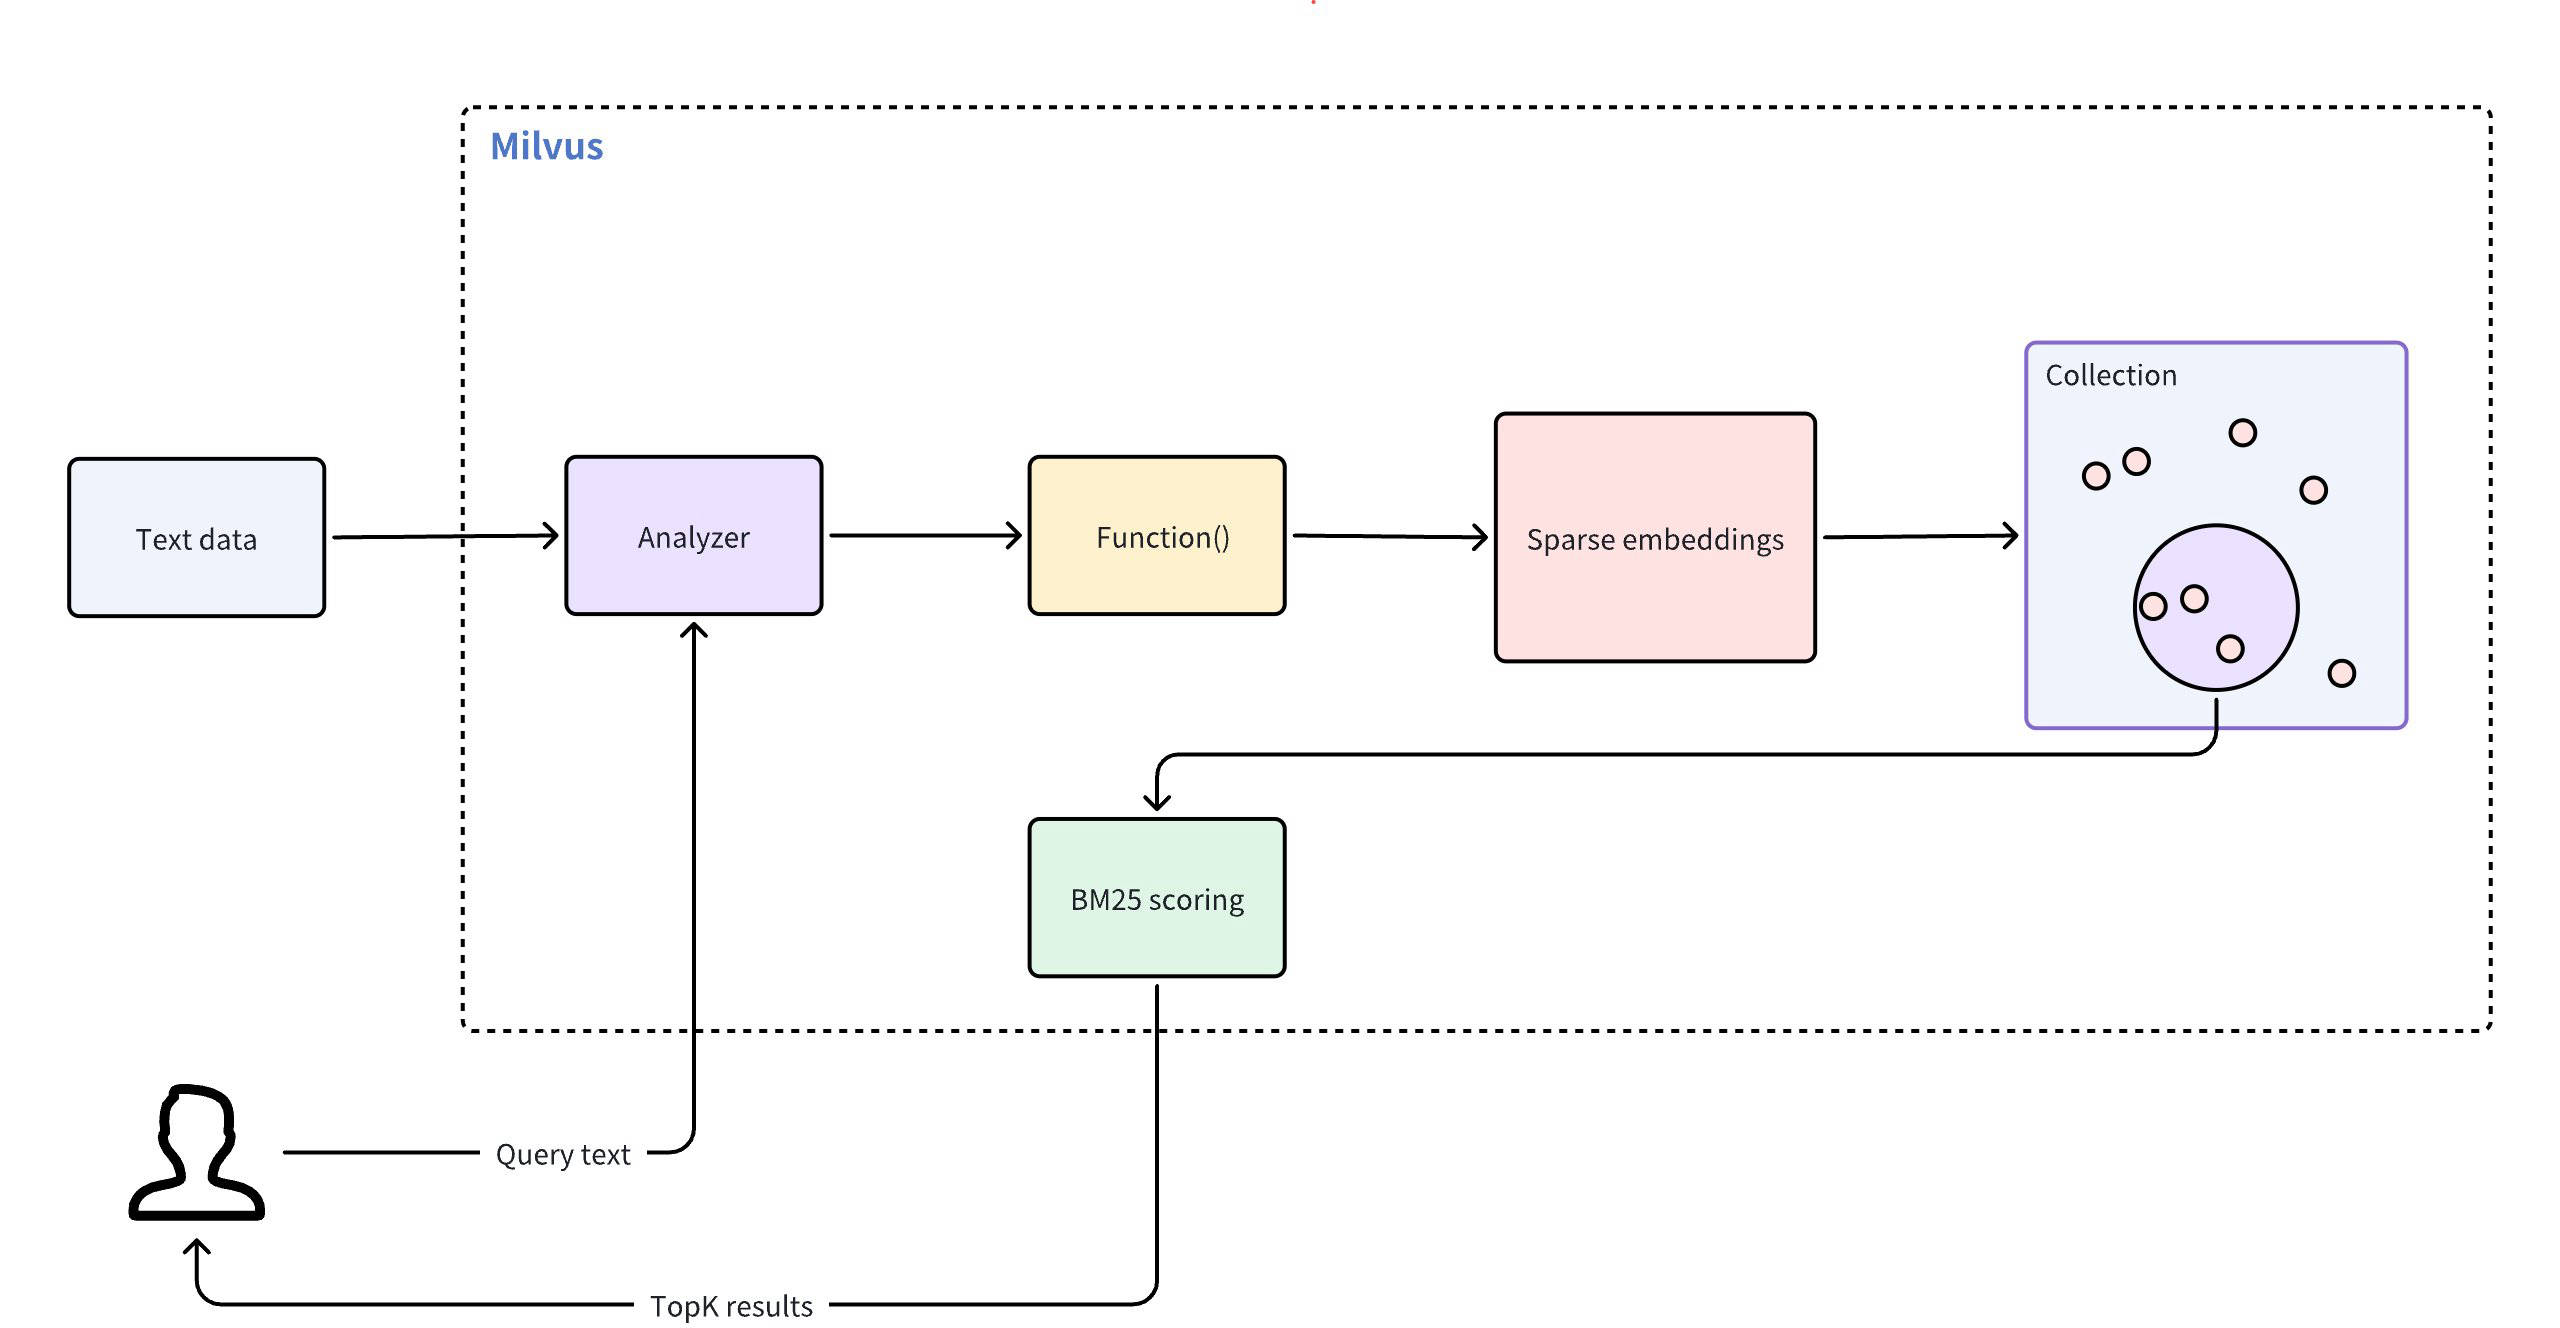

# 如何使 collections 支持全文搜索
在 collection 的 schema 中：
- 一个VARCHAR 字段，用于存储原始文本文档，其enable_analyzer 属性设置为True 。这允许 Milvus 将文本标记为特定术语，以便进行函数处理。
- 一个SPARSE_FLOAT_VECTOR 字段，预留用于存储稀疏嵌入，Milvus 将为VARCHAR 字段自动生成稀疏嵌入。 

## 定义 schema


In [ ]:
from pymilvus import MilvusClient, DataType, Function, FunctionType

client = MilvusClient(
    uri="http://localhost:19530",
    token="root:Milvus"
)

schema = client.create_schema()

schema.add_field(field_name="id", datatype=DataType.INT64, is_primary=True, auto_id=True)
schema.add_field(field_name="text", datatype=DataType.VARCHAR, max_length=1000, enable_analyzer=True)
schema.add_field(field_name="sparse", datatype=DataType.SPARSE_FLOAT_VECTOR)

## 定义一个将文本转换为稀疏向量表示的函数，然后将其添加到 Schema 中

In [ ]:
bm25_function = Function(
    name="text_bm25_emb", # Function name
    input_field_names=["text"], # Name of the VARCHAR field containing raw text data
    output_field_names=["sparse"], # Name of the SPARSE_FLOAT_VECTOR field reserved to store generated embeddings
    function_type=FunctionType.BM25, # Set to `BM25`
)

schema.add_function(bm25_function)

## 配置索引


In [ ]:
index_params = client.prepare_index_params()

index_params.add_index(
    field_name="sparse",

    index_type="SPARSE_INVERTED_INDEX",
    metric_type="BM25",
    params={
        "inverted_index_algo": "DAAT_MAXSCORE",
        "bm25_k1": 1.2,
        "bm25_b": 0.75
    }

)
